In [1]:
# Irfandy Rayhan Caesario
# Created at September 19, 2020

from datetime import date, timedelta
import pandas as pd
import re, string
import tweepy
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import math
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def update_data():
    # Membaca key dan secret untuk mengakses API Twitter
    kunci_list = open("kunci segala gembok.txt", "r")
    kunci = kunci_list.readlines()
    consumer_key = str(kunci[0].split()[0])
    consumer_secret = str(kunci[1].split()[0])
    access_token = str(kunci[2].split()[0])
    access_token_secret = str(kunci[3].split()[0])

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit = True)
    
    # Default pencarian adalah dari tanggal penggunaan
    search_words = "vaksin covid"
    until_date = date.today()
    since_date = until_date - timedelta(days = 5)
    new_search = search_words + " -filter:retweets"

    # Inisiasi pencarian dengan kriteria yang sudah ditentukan
    tweets = tweepy.Cursor(api.search,
            q = new_search,
            lang = "id",
            since = since_date).items()

    # Data yang diambil adalah username, tanggal tweet, tweet, dan id user
    username = []
    tanggal = []
    mentah = []
    clean = []  # Disiapkan untuk tweet yang sudah diproses nantinya
    ids = []
    sentimen = []  # Disiapkan untuk nilai sentimen
    for tweet in tweets:
        ids.append(tweet.id)
        sentimen.append(-9999)  # Nilai awal sentimen
        mentah.append(tweet.text)
        username.append("@%s" %(tweet.user.screen_name))
        tanggal.append(tweet.created_at.date())
        def hapus_tanda(tweet): 
            tanda_baca = set(string.punctuation)
            tweet = ''.join(ch for ch in tweet if ch not in tanda_baca)
            return tweet

        def hapus_hurufdouble(s): 
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            return pattern.sub(r"\1\1", s)

        tweet = tweet.text.lower()
        tweet = re.sub(r'\\u\w\w\w\w', '', tweet)
        
        # Menghapus tautan
        tweet = re.sub(r'http\S+','',tweet)

        # Menghapus @username
        tweet = re.sub('@[^\s]+','',tweet)

        # Menghapus tagar 
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

        # Menghapus tanda baca
        tweet = hapus_tanda(tweet)

        # Menghapus angka dan angka yang berada dalam string 
        tweet = re.sub(r'\w*\d\w*', '',tweet).strip()

        # Menghapus repetisi karakter 
        tweet = hapus_hurufdouble(tweet)

        # Stemming
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        tweet = stemmer.stem(tweet)
        clean.append(tweet)

    # Masukkan list ke dataframe
    d = {"ID": ids, "Username": username, "Tanggal": tanggal, "Tweet": mentah, "Tweet_Cleaned": clean, "Sentimen_Vaksin": sentimen}
    hasil = pd.DataFrame(data = d)

    items = []
    for i in hasil["Tweet_Cleaned"]:
        items.append(i)

    data_sql = [tuple(line) for line in hasil.values]
    conn = sqlite3.connect("Covid Vaccine Sentiment Analysis.db")
    c = conn.cursor()
    c.execute ("""CREATE TABLE IF NOT EXISTS tweet_vaksin (
                ID INTEGER PRIMARY KEY,
                username TEXT NOT NULL,
                tanggal TIMESTAMP NOT NULL,
                tweet_asli TEXT NOT NULL,
                tweet_clean TEXT NOT NULL,
                sentimen INTEGER)""")
    c.executemany("INSERT OR IGNORE INTO tweet_vaksin VALUES(?, ?, ?, ?, ?, ?);", data_sql)
    conn.commit()
    conn.close()
    
def update_sentimen():
    conn = sqlite3.connect("Covid Vaccine Sentiment Analysis.db")
    c = conn.cursor()
    query_results = c.execute("""SELECT * from tweet_vaksin""").fetchall()
    column = ["ID", "Username", "Tanggal", "Tweet", "Tweet_Cleaned", "Sentimen_Vaksin"]
    df = pd.DataFrame(query_results, columns = column)

    filt_sentimen = df["Sentimen_Vaksin"] == -9999
    items = []
    for i in df.loc[filt_sentimen, "Tweet_Cleaned"]:
        items.append(i)

    pos_list = open("./kata_positif.txt","r")
    pos_kata = pos_list.readlines()
    neg_list = open("./kata_negatif.txt","r")
    neg_kata = neg_list.readlines()

    sentimen = []
    count_p = 0
    count_n = 0
    for item in items:
        for kata_pos in pos_kata:
            if kata_pos.strip() in item:
                count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip() in item:
                count_n += 1
        sentimen.append(count_p - count_n)

    df.loc[filt_sentimen, "Sentimen_Vaksin"] = sentimen

    update_sentimen = [tuple(line) for line in df.values]
    c.executemany("INSERT OR REPLACE INTO tweet_vaksin VALUES(?, ?, ?, ?, ?, ?);", update_sentimen)
    conn.commit()
    conn.close()
    
def show_tweet_by_date():
    since = input("Tanggal Awal (yyyy-mm-dd): ")
    until = input("Tanggal Akhir (yyyy-mm-dd): ")
    conn = sqlite3.connect("Covid Vaccine Sentiment Analysis.db")
    c = conn.cursor()
    query_results = c.execute("SELECT username, tanggal, tweet_asli FROM tweet_vaksin WHERE tanggal BETWEEN ? AND ?", (since, until)).fetchall()
    column = ["Username", "Tanggal", "Tweet"]
    df = pd.DataFrame(query_results, columns = column)
    print (df)
    conn.close()
    
def sentimen_visual_by_date():
    since = input("Tanggal Awal (yyyy-mm-dd): ")
    until = input("Tanggal Akhir (yyyy-mm-dd): ")
    conn = sqlite3.connect("Covid Vaccine Sentiment Analysis.db")
    c = conn.cursor()
    query_results = c.execute("SELECT * FROM tweet_vaksin WHERE tanggal BETWEEN ? AND ?", (since, until)).fetchall()
    column = ["ID", "Username", "Tanggal", "Tweet", "Tweet_Cleaned", "Sentimen_Vaksin"]
    df = pd.DataFrame(query_results, columns = column)
    
    print ("Nilai rata-rata: "+str(np.mean(df["Sentimen_Vaksin"])))
    print ("Nilai median: "+str(np.median(df["Sentimen_Vaksin"])))
    print ("Standar deviasi: "+str(np.std(df["Sentimen_Vaksin"])))

    plt.figure(figsize = (15, 8))
    labels, counts = np.unique(df["Sentimen_Vaksin"], return_counts = True)
    plt.bar(labels, counts, align = 'center')
    plt.gca().set_xticks(labels)
    plt.xticks(rotation = 90)
    plt.title("Sentimen mengenai Vaksin")
    plt.xlabel("Nilai Sentimen")
    plt.ylabel("Total")
    plt.show()
    
def menu_awal():
    x = ''
    while True:
        if x == "1":
            update_data()
        elif x == "2":
            update_sentimen()
        elif x == "3":
            show_tweet_by_date()
        elif x == "4":
            sentimen_visual_by_date()
        elif x == "5":
            print("Terima kasih, sampai jumpa lagi!")
            break
        x = input("""Apa yang ingin Anda lakukan?
              1. Update Data
              2. Update Nilai Sentimen
              3. Lihat Data
              4. Visualisasi Data
              5. Keluar
              Masukkan angkanya: """)

In [2]:
update_data()

In [3]:
update_sentimen()

Apa yang ingin Anda lakukan?
              1. Update Data
              2. Update Nilai Sentimen
              3. Lihat Data
              4. Visualisasi Data
              5. Keluar
              Masukkan angkanya: 2020-10-06
Apa yang ingin Anda lakukan?
              1. Update Data
              2. Update Nilai Sentimen
              3. Lihat Data
              4. Visualisasi Data
              5. Keluar
              Masukkan angkanya: 3
Tanggal Awal (yyyy-mm-dd): 2020-10-06
Tanggal Akhir (yyyy-mm-dd): 2020-10-08
              Username     Tanggal  \
0             @jawapos  2020-10-06   
1     @kraksaan_online  2020-10-06   
2             @jawapos  2020-10-06   
3          @Twelve0urs  2020-10-06   
4        @detikfinance  2020-10-06   
...                ...         ...   
1012   @ptautoimuncare  2020-10-08   
1013         @gizitips  2020-10-08   
1014        @sunat1231  2020-10-08   
1015  @AyuPurn55698726  2020-10-08   
1016       @tempodotco  2020-10-08   

                     

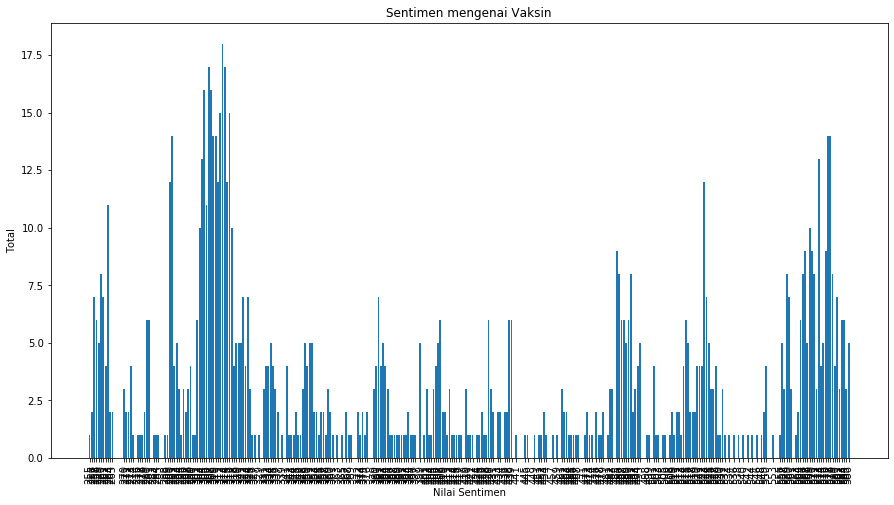

Apa yang ingin Anda lakukan?
              1. Update Data
              2. Update Nilai Sentimen
              3. Lihat Data
              4. Visualisasi Data
              5. Keluar
              Masukkan angkanya: 5
Terima kasih, sampai jumpa lagi!


In [5]:
menu_awal()

In [6]:
menu_awal()

Apa yang ingin Anda lakukan?
              1. Update Data
              2. Update Nilai Sentimen
              3. Lihat Data
              4. Visualisasi Data
              5. Keluar
              Masukkan angkanya: 3
Tanggal Awal (yyyy-mm-dd): 2020-10-06
Tanggal Akhir (yyyy-mm-dd): 2020-10-08
              Username     Tanggal  \
0             @jawapos  2020-10-06   
1     @kraksaan_online  2020-10-06   
2             @jawapos  2020-10-06   
3          @Twelve0urs  2020-10-06   
4        @detikfinance  2020-10-06   
...                ...         ...   
1012   @ptautoimuncare  2020-10-08   
1013         @gizitips  2020-10-08   
1014        @sunat1231  2020-10-08   
1015  @AyuPurn55698726  2020-10-08   
1016       @tempodotco  2020-10-08   

                                                  Tweet  
0     Bali Tempat Uji Coba Kedua Penyuntikan Vaksin ...  
1     Belum Ada Vaksin Yang Dapat Sembuhkan COVID-19...  
2     Menristek: Vaksin Merah Putih untuk Covid-19 H...  
3     Kenapa DPR